# Baseline Modeling - Classification

---

In addition to regression modeling for the Average Daily Rate, I want to perform classification modeling to determine the likelihood of a reservation cancellation. This project was initially focused on classification, and I feel it's worthwhile to re-examine this classification challenge.

---

# Import Packages and Load Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

In [4]:
## Load combined dataset
df_data = pd.read_parquet('../../data/source/full_data.parquet')
df_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelNumber
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,H1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,August,35,30,2,5,2,0.0,...,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,H2
119386,0,102,2017,August,35,31,2,5,3,0.0,...,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,H2
119387,0,34,2017,August,35,31,2,5,2,0.0,...,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,H2
119388,0,109,2017,August,35,31,2,5,2,0.0,...,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,H2


# Review Target: `ReservationStatus`

In [5]:
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.36
No-Show      0.01
Name: proportion, dtype: float64

## Target Feature Class Imbalance

---

The "No-Show" category is extremely infrequent and will be hard to predict. For simplicity, I will convert cases of "no-show" reservations to "Canceled."

---

In [6]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'No-Show', 'Canceled', df_data['ReservationStatus'])
df_data.loc[:, 'ReservationStatus']

0         Check-Out
1         Check-Out
2         Check-Out
3         Check-Out
4         Check-Out
            ...    
119385    Check-Out
119386    Check-Out
119387    Check-Out
119388    Check-Out
119389    Check-Out
Name: ReservationStatus, Length: 119390, dtype: object

In [7]:
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Modeling Pipeline

## Train/Test Split

In [8]:
## Train/Test Split
X = df_data.drop(columns = 'ReservationStatus')
y = df_data['ReservationStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 903,
                                                    stratify= y)

# Initial Model - Random Forest Classifier

---

I'm starting with a `RandomForestClassifier` model due to its robust and accurate performance history.

I expect this model to overfit without performing any hyperparameter tuning or handling of class imbalances. I will address both problems in the revised modeling.

---

In [15]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 25))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample',))])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCa...
                                                                                 max_categories=25,
                                                                                 min_frequency=10,
                                                                                 sparse_output=False))]),
                                                  Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'Agent', 'Company', 'CustomerType',
       'ReservationStatusDate', 'HotelNumber'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample'))])

In [16]:
print(f'Training Score: {model_pipeline.score(X_train, y_train)}')
print(f'Testing Score: {model_pipeline.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 1.0


              precision    recall  f1-score   support

    Canceled       1.00      1.00      1.00     11056
   Check-Out       1.00      1.00      1.00     18792

    accuracy                           1.00     29848
   macro avg       1.00      1.00      1.00     29848
weighted avg       1.00      1.00      1.00     29848



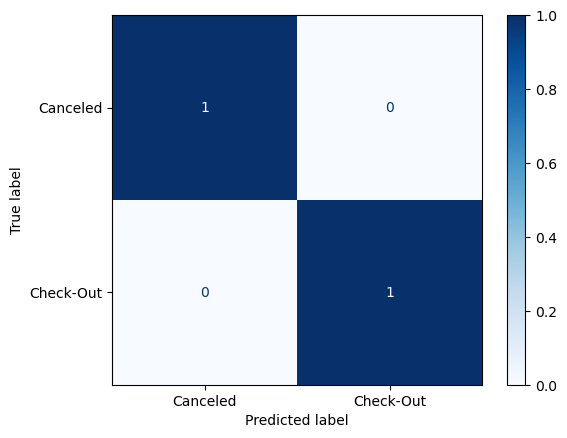

In [19]:
y_pred = model_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

In [ ]:

## Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=903)

## Fit the model and generate predictions
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, n_jobs=-1, scoring='f1')

## Evaluate performance metrics
print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

              precision    recall  f1-score   support

    Canceled       0.57      0.47      0.51     44224
   Check-Out       0.72      0.79      0.75     75166

    accuracy                           0.67    119390
   macro avg       0.64      0.63      0.63    119390
weighted avg       0.66      0.67      0.66    119390



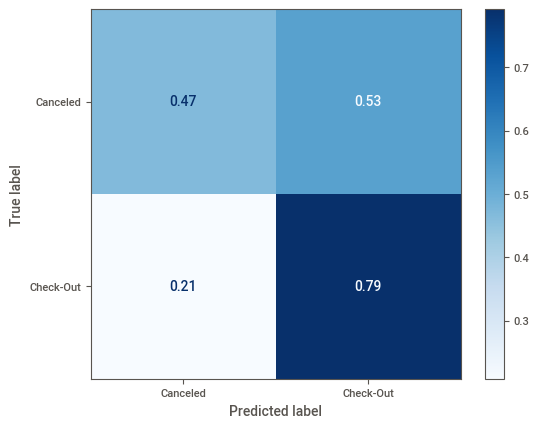

In [ ]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# print(classification_report(y_test, y_pred))
print(classification_report(y, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

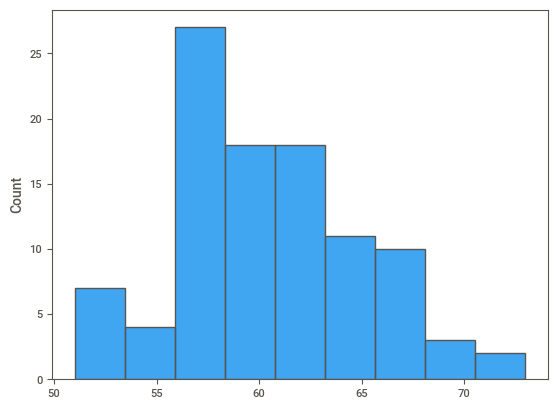

In [ ]:
# Fit the pipeline with your data
model_pipeline.fit(X, y)

# Access the fitted model
fitted_model = model_pipeline[-1]

# Now you can get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in fitted_model.estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Random Forest Classifier - Revised

---

As part of my revisions, I am performing a GridSearch to tune my hyperparameters

In [ ]:
## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=25,
                                                   max_categories = 100))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))])

# Set up hyperparameter tuning 
param_grid = {
    # 'preprocessor__cat__encoder__min_frequency': [5, 10],
    'preprocessor__cat__encoder__max_categories': [25, 50, 100],
    'classifier__max_depth': [50, 75],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [2, 4]
}

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5)

search = GridSearchCV(model_pipeline,
                      param_grid=param_grid,
                      scoring='f1_micro',
                      cv=skf,
                      n_jobs=-1)

# Fit the model and find the best hyperparameters
search.fit(X_train, y_train)

# Extract the best model
best_model = search.best_estimator_

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='f1_micro', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [0.68975626 0.725312   0.64293492 0.59682553 0.71287378]
Mean CV Score: 0.674
Standard Deviation of CV Scores: 0.048



              precision    recall  f1-score   support

    Canceled       0.57      0.50      0.53     44224
   Check-Out       0.73      0.78      0.75     75166

    accuracy                           0.67    119390
   macro avg       0.65      0.64      0.64    119390
weighted avg       0.67      0.67      0.67    119390



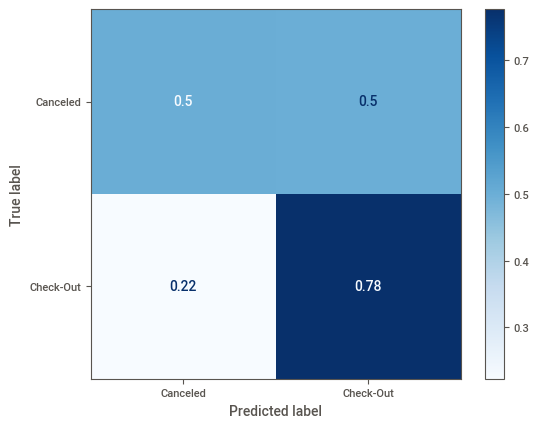

In [ ]:
# Generate cross-validated predictions
y_pred_cv = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)

# Evaluate performance metrics
print(classification_report(y, y_pred_cv))
ConfusionMatrixDisplay.from_predictions(y, y_pred_cv, cmap='Blues', normalize='true');

# HistGradientBoostingClassifier

In [ ]:
# for col in X_train.select_dtypes(include=['object']).columns:
#     X_train[col] = df_data[col].astype('category')
    
# for col in X_test.select_dtypes(include=['object']).columns:
#     X_test[col] = df_data[col].astype('category')

In [32]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 50))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

# Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', HistGradientBoostingClassifier())])

best_model = model_pipeline.fit(X_train, y_train)

# # Set up hyperparameter tuning with HalvingGridSearchCV
# param_grid = {
#     'preprocessor__cat__encoder__min_frequency': [5, 10, 15],
#     'preprocessor__cat__encoder__max_categories': [50, 100, 250],
#     'classifier__learning_rate': [0.01, 0.1, 0.2],
#     'classifier__max_iter': [100, 200],
#     'classifier__max_depth': [10, 15, 20],
#     'classifier__min_samples_leaf': [2, 4],
#     'classifier__max_leaf_nodes': [25, 50, 100]
# }

# # Define the stratified k-fold cross-validator
# skf = StratifiedKFold(n_splits=5)

# search = GridSearchCV(model_pipeline,
#                       param_grid=param_grid,
#                       scoring='f1_micro',
#                       cv=skf,
#                       n_jobs=-1)

# # Fit the model and find the best hyperparameters
# search.fit(X_train, y_train)

# Extract the best model
best_model = search.best_estimator_

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='f1_micro', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

KeyboardInterrupt: 

              precision    recall  f1-score   support

    Canceled       0.58      0.56      0.57     44224
   Check-Out       0.75      0.76      0.75     75166

    accuracy                           0.69    119390
   macro avg       0.66      0.66      0.66    119390
weighted avg       0.68      0.69      0.68    119390



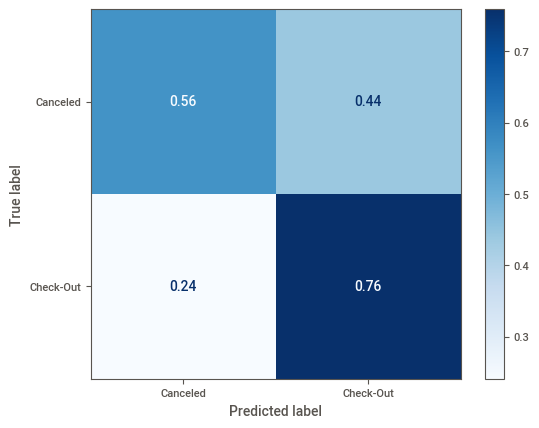

In [30]:
# Generate cross-validated predictions
y_pred_cv = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)

# Evaluate performance metrics
print(classification_report(y, y_pred_cv))
ConfusionMatrixDisplay.from_predictions(y, y_pred_cv, cmap='Blues', normalize='true');

# Results

---

My final results show that a RandomForestClassifier model performs the best when evaluated by the F1 score. The models struggle with the class imbalance, as expected, but I'm hopeful that additional feature engineering will help improve the scores.

---